In [74]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

In [75]:
def broad_filter(res_cases):
    # filter out cases with irrelevant type codes
    types = ['PL_MINSP', 'PL_SSP_SM', 'PL_SSM_SM2', 'PL_CPAA', 'PL_MINPP', 'PL_MAJSP', 'PL_MAJSUP', 'PL_PPA', 'PL_MAJPP']
    filter_cases_type = res_cases[res_cases['A_TYPE'].isin(types)]

    # filter out cases with out of date status
    status = res_cases['A_STATUS'].unique()
    status = status[~np.isin(status, ['WITH', 'VOID','DEN','DISAP','EXP'])]
    filter_cases_status = filter_cases_type[filter_cases_type['A_STATUS'].isin(status)]

    # keep entries with keywords
    keywords = ['home', 'family', 'residen', 'mixed', 'mized', 'duplex', 'apartment', ' housing', 'condo', 'dwelling', 'tenant', 'affordable', 'units', 'townhouse']
    pattern = '|'.join(keywords)
    filtered_in = filter_cases_status[filter_cases_status['A_DESCRIPT'].str.contains(pattern, case=False, na=False)]

    # remove entries with certain words
    keywords_avoid = ['expand','storage']
    pattern_avoid = '|'.join(keywords_avoid)
    filtered_words = filtered_in[~filtered_in['A_DESCRIPT'].str.contains(pattern_avoid, case=False, na=False)]

    # filter out entries that were last updated over 5 years ago
    filtered_words = filtered_words.copy()
    filtered_words['A_STATUS_D'] = pd.to_datetime(filtered_words['A_STATUS_D'])
    filtered_final = filtered_words[filtered_words['A_STATUS_D'].dt.year>=2020]

    return filtered_final

In [76]:
def normalize_for_regex(term):
    # makes it so string returns a match whether a term has spaces, dashes, both, or neither
    return re.sub(r'[-\s]+', r'\\s*-?\\s*', term)

In [77]:
def extract_units(description):
    # remove square footage references
    description = re.sub(
        r'(\d+|\d{1,3}(,\d{3})*)(\s+[A-Za-z-]+){0,2}?\s*(SF|square feet|sq\.?\s*ft\.?|sqft)',
        '', description, flags=re.IGNORECASE
    )

    # map variations to standardized types
    term_map = {
        "home": "home", "homes": "home", "house": "home", "houses": "home",
        "duplex": "duplex", "duplexes": "duplex",
        "condo": "condo", "condominium": "condo", "condominiums": "condo", "condos": "condo", 
        "apartment": "apartment", "apartments": "apartment",
        "townhome": "townhouse", "townhomes": "townhouse",
        "townhouse": "townhouse", "townhouses": "townhouse",
        "town home": "townhouse", "town homes": "townhouse",
        "town house": "townhouse", "town houses": "townhouse",
        "multifamily": "multifamily", "multi-family": "multifamily", 
        "multi - family": "multifamily", "multi family": "multifamily",
        "mutifamily": "multifamily", "MF": "multifamily",
        "single family": "single family", "single-family": "single family", 
        "single - family": "single family", "s-f": "single family", "s - f": "single family", "s f": "single family"
    }

    modifiers = ["attached", "detached"]
    suffixes = ["units", "lots", "homes", "houses"]

    housing_pattern = "|".join([normalize_for_regex(term) for term in term_map])
    modifier_pattern = "|".join(modifiers)
    suffix_pattern = "|".join(suffixes)

    # extended match pattern to support both "qty before type" and "type before qty"
    match_pattern = rf'''
    (?:
        # Qty before type
        (?P<qty>\(?\d{{1,4}}\)?)
        (?:\s*[-+&/]?\s*)?
        (?:({modifier_pattern})\s*){{0,2}}?
        (?:\w+\s*){{0,4}}?
        (?P<type>{housing_pattern})
        (?:\s+({modifier_pattern}))?
        (?:\s+(?P<suffix>{suffix_pattern}))?

    |
        # Type before qty
        (?P<type2>{housing_pattern})
        (?:\s+({modifier_pattern}))?
        (?:\s*[-+&/]?\s*)?
        (?:\w+\s*){{0,4}}?
        (?P<qty2>\(?\d{{1,4}}\)?)
        (?:\s+(?P<suffix2>{suffix_pattern}))?

    |
        # Type with quantity in parentheses
        (?P<type3>{housing_pattern})
        (?:\s+\w+){{0,4}}?
        \(\s*(?P<qty3>\d{{1,4}})\s+(?P<suffix3>{suffix_pattern})\s*\)
    )
'''

    matches = re.finditer(match_pattern, description, flags=re.IGNORECASE | re.VERBOSE)
    
    result = []
    for match in matches:
        qty = match.group("qty") or match.group("qty2")
        raw_type = match.group("type") or match.group("type2")
        raw_mod = match.group(2)  # first modifier (position varies)
        raw_suffix = match.group("suffix") or match.group("suffix2")

        if not qty or not raw_type:
            continue  # skip malformed matches

        # normalize type
        norm_key = re.sub(r'[-\s]+', ' ', raw_type.lower()).strip()
        normalized_type = term_map.get(norm_key, norm_key)

        result.append((
            int(qty.strip("()")),
            raw_mod.lower() if raw_mod else None,
            normalized_type,
            raw_suffix.lower() if raw_suffix else None
        ))

    return result

In [78]:
def fill_types(match_results):
    housing_types = ['sf_detached', 'sf_attached', 'duplex/triplex', 'multifamily', 'condo']
    housing_type_dict = {
        'townhouse': 'sf_attached',
        'home': 'sf_detached', 'single family': 'sf_detached',
        'duplex': 'duplex/triplex',
        'apartment': 'multifamily', 'multifamily': 'multifamily',
        'condo': 'condo'
    }

    row_data = {h_type: 0 for h_type in housing_types}
    for group in match_results:
        quantity = group[0]
        mod = group[1]
        housing = group[2]

        if housing == 'single family' and mod == 'attached':
            row_data['sf_attached'] += quantity
        elif housing in housing_type_dict:
            row_data[housing_type_dict[housing]] += quantity

    return pd.Series(row_data)

In [79]:
durham_dev_filename = input('Please input the name of the Durham developments shapefile: ').strip()
res_cases_raw = gpd.read_file(f'../data/{durham_dev_filename}')
res_filtered = broad_filter(res_cases_raw)
res_filtered['match_results'] = res_filtered['A_DESCRIPT'].apply(extract_units)
housing_counts = res_filtered['match_results'].apply(fill_types)
filtered_final = pd.concat([res_filtered, housing_counts], axis=1)
filtered_final = filtered_final.to_crs('EPSG:4326')

In [80]:
# read data from Data+_2025/data/enrollment_projections/sgr_table_region_2324_20240710.xlsx in Google Drive
'''
read in SGR data -- file paths: 
the current one is from 2024 July 10th, the file is already in data and is named sgr_tables_htype_reg.xlsx
'''
sgr_filename = input('Please enter the file name which includes the table of SGRs by housing type and region: ')
sgr_data = gpd.read_file(f'../data/{sgr_filename}')

c:\Users\kevan\anaconda3\Lib\site-packages\pyogrio\geopandas.py:275: UserWarning: More than one layer found in 'sgr_tables_htype_reg.xlsx': 'all sgrs' (default), 'for itre', 'for city - dps', 'for city - all ', 'dictionary', 'for report'. Specify layer parameter to avoid this warning.
  result = read_func(


In [81]:
# remove null values and shorten to only use relevant columns
sgr_data = sgr_data.dropna()
sgr_data.rename(columns={'sgr_dps_2324_all.1': 'sgr_dps_avg_k12'}, inplace=True) # because there might be a typo in the file?
sgr_data = sgr_data[['housing_type','region','sgr_dps_avg_k12']]
sgr_data['sgr_dps_avg_k12'] = sgr_data['sgr_dps_avg_k12'].round(4)
sgr_data.set_index(['region', 'housing_type'], inplace=True)

In [82]:
filtered_final.columns

Index(['A_NUMBER', 'A_TYPE', 'A_DATE', 'A_STATUS', 'A_STATUS_D', 'A_PROJECT_',
       'A_DESCRIPT', 'A_USER_ID', 'A_CASE_PLA', 'StatCode', 'AppStatus',
       'AppCode', 'AppType', 'CasePlanne', 'EMAIL', 'ORIG_FID', 'CreationDa',
       'Creator', 'EditDate', 'Editor', 'geometry', 'match_results',
       'sf_detached', 'sf_attached', 'duplex/triplex', 'multifamily', 'condo'],
      dtype='object')

In [ ]:
'''
read in shapefile to get geometries for Durham County regions from Data+_2025/QGIS/DPS shapefiles from layers in Google Drive
'''
regions = gpd.read_file(r'../data/durham_regions.geojson')[['region', 'geometry']]
regions = regions.to_crs('EPSG:4326')
#read in geojson with residential developments
# ''' 
# read in geojson with residential developments -- file paths: 
# Leah: /Users/leahwallihan/Durham_school_planning/DPS-Planning/GIS_files/resdev_cases.geojson'''
# res_dev = gpd.read_file(r'/Users/kevan/OneDrive/Desktop/Data+/DPS-Planning/GIS_files/resdev_cases.geojson')
# res_dev = res_dev.to_crs('EPSG:4326')
# res_dev

,region,geometry
0,Central,"MULTIPOLYGON (((-78.89217 36.0348, -78.89154 3..."
1,East,"MULTIPOLYGON (((-78.7402 36.02356, -78.74019 3..."
2,North,"MULTIPOLYGON (((-78.80489 36.08853, -78.80558 ..."
3,Southeast,"MULTIPOLYGON (((-78.86421 35.95016, -78.86332 ..."
4,Southwest,"MULTIPOLYGON (((-78.90379 35.94973, -78.9038 3..."


In [ ]:
# function to count number of students in each row
def count_students(row): 
        
    htype_map = {
        'sf_detached': 'sf_detach',
        'sf_attached': 'sf_attach',
        'duplex/triplex': 'du_tri',
        'multifamily': 'mf_apt',
        'condo': 'condo'
    }

    region = row['region']

    total = 0
    for col_name, sgr_col in htype_map.items():
        count = row.get(col_name, 0)

        try:
            multiplier = sgr_data.loc[(region, sgr_col), 'sgr_dps_avg_k12']
        except KeyError:
            multiplier = 0

        total += count * multiplier

    return total

In [89]:
filtered_final

,A_NUMBER,A_TYPE,A_DATE,A_STATUS,A_STATUS_D,A_PROJECT_,A_DESCRIPT,A_USER_ID,A_CASE_PLA,StatCode,...,Creator,EditDate,Editor,geometry,match_results,sf_detached,sf_attached,duplex/triplex,multifamily,condo
90,D2000291,PL_MINSP,2020-12-02,APP,2021-09-03,Umstead Grove Conservation Subdivision,"50 Single - family lots, 1 stormwater pond, ad...",JESSICADO,COURTNEYMC,APP,...,gisproc_sys,2025-07-17,gisproc_sys,POINT (-78.94561 36.07502),"[(50, None, single family, lots)]",50,0,0,0,0
139,D2200173,PL_MINSP,2022-05-25,APP,2023-02-01,Pineview Glen Town homes - Mass Grading,Mass grading only site plan for residential to...,JUSTINH,KEAGANSA,APP,...,gisproc_sys,2025-07-17,gisproc_sys,POINT (-78.81052 35.92777),[],0,0,0,0,0
224,D1800378,PL_MINSP,2018-11-28,APP,2020-04-14,Elan Innovation District,Mixe of uses including retail and residential....,JOHNRA,TREYFI,APP,...,gisproc_sys,2025-07-17,gisproc_sys,POINT (-78.90421 35.99991),[],0,0,0,0,0
242,D2100156,PL_MINSP,2021-06-04,APP,2022-02-02,ALTA Rutherford,Multifamily Apartments,KIMRO,TREYFI,APP,...,gisproc_sys,2025-07-17,gisproc_sys,POINT (-78.92991 36.01005),[],0,0,0,0,0
265,D1900171,PL_MINSP,2019-05-30,APP,2020-04-03,Ellis Road Phase 3,"37 Townhome units, 102 Attached S-F units (cal...",ROBINSH,COLERE,APP,...,gisproc_sys,2025-07-17,gisproc_sys,POINT (-78.86167 35.9519),"[(37, None, townhouse, units), (102, None, sin...",248,37,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21416,D2500149,PL_MINSP,2025-06-23,UN_RE,2025-06-23,Mt. Moriah II-By Right,"156 Units, totaling approximately 65,594 sq. ft.",JONATHANBR,TREYFI,UN_RE,...,gisproc_sys,2025-07-17,gisproc_sys,POINT (-78.99127 35.94527),[],0,0,0,0,0
21423,D2500150,PL_MINSP,2025-06-23,UN_RE,2025-06-23,Mt. Moriah II-Affordable,"152 Units, totaling approximately 59,136 sq. ft.",JONATHANBR,COLERE,UN_RE,...,gisproc_sys,2025-07-17,gisproc_sys,POINT (-78.99196 35.94594),[],0,0,0,0,0
21445,D2500158,PL_MINSP,2025-06-30,UN_RE,2025-06-30,5802 S Miami Blvd Multi-Family,369-unit multi-family building with structured...,SKNOX,TREYFI,UN_RE,...,gisproc_sys,2025-07-17,gisproc_sys,POINT (-78.85182 35.87137),"[(369, None, multifamily, None)]",0,0,0,369,0
21446,D2500159,PL_MINSP,2025-06-30,UN_RE,2025-06-30,Mineral Springs Road Towns,46 townhome lots with 3 open space lots with a...,FRANCISCOM,COLERE,UN_RE,...,gisproc_sys,2025-07-17,gisproc_sys,POINT (-78.83615 35.96064),"[(46, None, townhouse, lots)]",0,46,0,0,0


In [ ]:

        try:
            multiplier = sgr_data.loc[(region, sgr_col), 'sgr_dps_avg_k12']
        except KeyError:
            multiplier = 0

        total += count * multiplier

    return total

In [88]:
filtered_final['student_gen'] = filtered_final.apply(count_students, axis=1)

KeyError: 'region'

In [ ]:
filtered_final[['region', 'sf_detached', 'sf_attached', 'multifamily', 'student_gen']]

,region,sf_detached,sf_attached,multifamily,student_gen
0,North,50,0,0,13.4350
1,East,0,0,0,0.0000
2,Central,0,0,0,0.0000
3,Central,0,0,0,0.0000
4,East,248,37,0,56.7421
...,...,...,...,...,...
265,Southwest,0,0,324,60.6852
266,Southeast,0,33,0,1.9404
267,Southwest,0,0,0,0.0000
268,Southeast,88,0,0,18.9200


In [ ]:
#filtered_final.to_file('resdev_with_stu_proj.geojson', driver='GeoJSON')

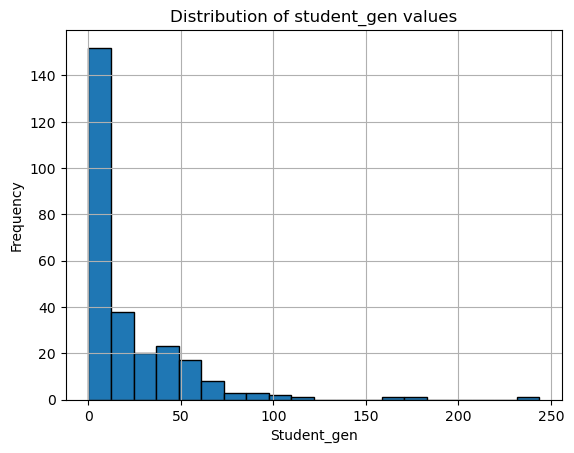

In [ ]:
filtered_final["student_gen"].plot.hist(bins=20, edgecolor='black')

plt.xlabel("Student_gen")
plt.ylabel("Frequency")
plt.title("Distribution of student_gen values")
plt.grid(True)

plt.show()

In [ ]:
# read in planning unit shapefile 
pu = gpd.read_file('/Users/leahwallihan/Durham_school_planning/geospatial files/pu_shape.geojson')[['OBJECTID', 'geometry']]
pu = pu.to_crs('EPSG:4326')

DataSourceError: '/Users/leahwallihan/Durham_school_planning/geospatial files/pu_shape.geojson' does not exist in the file system, and is not recognized as a supported dataset name.

In [ ]:
# fill missing values
filtered_final['pu'] = filtered_final['pu'].fillna(0).astype(int)

# get counts for each planning unit
pu_gen = filtered_final.groupby('pu')['student_gen'].sum()

KeyError: 'pu'

In [ ]:
pu['student_gen'] = pu['OBJECTID'].map(pu_gen).fillna(0).round().astype(int)

In [ ]:
# let's fix hs_full_geo
pu = pu.set_index('OBJECTID')

hs_full_geo = gpd.read_file('/Users/leahwallihan/Durham_school_planning/DPS-Planning/GIS_files/hs_full_geo.geojson')
hs_full_geo = hs_full_geo.set_index('pu_2324_84')

for i, row in pu.iterrows():
    hs_full_geo.loc[i, 'student_gen'] = row['student_gen']

# hs_full_geo.to_file('hs_full_geo.geojson', driver='GeoJSON')

In [ ]:
pu.to_file('pu_gen.geojson', driver='GeoJSON')

In [ ]:
res_dev.head(30)

,A_NUMBER,A_TYPE,A_DATE,A_STATUS,A_STATUS_D,A_PROJECT_,A_DESCRIPT,A_USER_ID,A_CASE_PLA,StatCode,...,match_results,sf_detached,sf_attached,duplex/triplex,multifamily,condo,region,pu,geometry,student_gen
0,D2000291,PL_MINSP,2020-12-02,APP,2021-09-03,Umstead Grove Conservation Subdivision,"50 Single - family lots, 1 stormwater pond, ad...",JESSICADO,COURTNEYMC,APP,...,"[(50, None, 'single family', 'lots')]",50,0,0,0,0,North,663,POINT (-78.94561 36.07501),13.4350
1,D2200173,PL_MINSP,2022-05-25,APP,2023-02-01,Pineview Glen Town homes - Mass Grading,Mass grading only site plan for residential to...,JUSTINH,KEAGANSA,APP,...,[ ],0,0,0,0,0,East,249,POINT (-78.81051 35.92776),0.0000
2,D1800378,PL_MINSP,2018-11-28,APP,2020-04-14,Elan Innovation District,Mixe of uses including retail and residential....,JOHNRA,TREYFI,APP,...,[ ],0,0,0,0,0,Central,819,POINT (-78.90421 35.99991),0.0000
3,D2100156,PL_MINSP,2021-06-04,APP,2022-02-02,ALTA Rutherford,Multifamily Apartments,KIMRO,TREYFI,APP,...,[ ],0,0,0,0,0,Central,802,POINT (-78.92991 36.01005),0.0000
4,D1900171,PL_MINSP,2019-05-30,APP,2020-04-03,Ellis Road Phase 3,"37 Townhome units, 102 Attached S-F units (cal...",ROBINSH,COLERE,APP,...,"[(37, None, 'townhouse', 'units'), (102, None,...",248,37,0,0,0,East,132,POINT (-78.86167 35.9519),56.7421
5,A1900003,PL_CPAA,2019-02-14,COM,2020-08-17,Cole Property,"From Rural Density Residential (RDR, 0.5DU/acr...",DCULTRA,EMILYST,COM,...,[ ],0,0,0,0,0,East,682,POINT (-78.77719 35.98944),0.0000
6,D2200181,PL_MINSP,2022-06-07,APP,2023-05-16,GTH Owner LLC,33 new town home lots with garages and mail ki...,COLERE,COLERE,APP,...,"[(33, None, 'townhouse', 'lots')]",0,33,0,0,0,Central,374,POINT (-78.89255 36.00264),1.0890
7,D2300150,PL_MINSP,2023-06-07,APP,2024-10-22,Hope Crossing II,32 single family units on small lots and 23 to...,TREYFI,TREYFI,APP,...,"[(32, None, 'single family', 'units'), (23, No...",32,23,0,0,0,East,470,POINT (-78.84504 35.99883),8.5919
8,D1900363,PL_MINSP,2019-10-09,APP,2021-07-21,Olive Branch West,"108 Single - Family lots, 2 stormwater ponds, ...",LROBERTSON,COLERE,APP,...,"[(108, None, 'single family', 'lots')]",108,0,0,0,0,East,468,POINT (-78.78659 35.96371),23.5872
9,D2100205,PL_MINSP,2021-07-15,APP,2021-11-29,The Village at Ellis Crossing,"397,000 Total SF: Apartments (264 units), Acce...",KIMRO,ROBINSH,APP,...,"[(264, None, 'apartment', 'units')]",0,0,0,264,0,East,700,POINT (-78.85819 35.94202),56.8656
